# 训练误差和泛化误差

# 模型选择

# 欠拟合还是过拟合

# 多项式回归

In [92]:
import math 
import numpy as np 
import torch 
from torch import nn 
from d2l import torch as d2l 

In [93]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [94]:
# NumPy ndarry 转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in (true_w, features, poly_features, labels)
]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.5256],
         [0.7108]]),
 tensor([[1.0000e+00, 5.2560e-01, 1.3813e-01, 2.4201e-02, 3.1800e-03, 3.3428e-04,
          2.9283e-05, 2.1988e-06, 1.4446e-07, 8.4366e-09, 4.4343e-10, 2.1188e-11,
          9.2804e-13, 3.7522e-14, 1.4087e-15, 4.9361e-17, 1.6215e-18, 5.0134e-20,
          1.4639e-21, 4.0497e-23],
         [1.0000e+00, 7.1077e-01, 2.5259e-01, 5.9845e-02, 1.0634e-02, 1.5117e-03,
          1.7907e-04, 1.8183e-05, 1.6155e-06, 1.2758e-07, 9.0679e-09, 5.8592e-10,
          3.4705e-11, 1.8974e-12, 9.6332e-14, 4.5646e-15, 2.0277e-16, 8.4779e-18,
          3.3477e-19, 1.2523e-20]]),
 tensor([5.3827, 5.2306]))

In [95]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [96]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.026734   1.2119871 -3.4546382  5.5434656]]


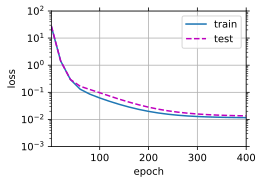

In [97]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.2116318 3.9037747]]


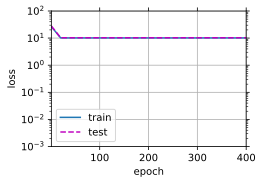

In [98]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.989771    1.2763405  -3.2787986   5.1494613  -0.48624855  1.007777
   0.12477925  0.10661019 -0.1231023  -0.05347823  0.02910461  0.04218608
   0.19557141 -0.12685971 -0.17934322 -0.14839435  0.09691554  0.20221916
   0.08893734  0.04743257]]


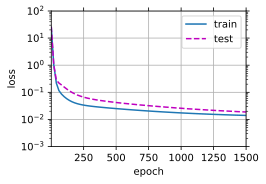

In [99]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)